In [135]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # Import NumPy

In [136]:
data_path = r'C:\Users\fadia\OneDrive\Desktop\Ody\Scripts\Transformed Data\Master Combined\Master_Sales_Data_2021-08-19_to_2025-07-22.csv'
df=pd.read_csv(data_path)
df['Day_Date'] = pd.to_datetime(df['Day_Date'])

In [137]:
mask = (df["Item"] == "Amstel Pint") & (df["Table"]!= 100) & (df["Table"]!= 200) & (df["Payment"]!= "Credit")
item_df = df[mask].copy()
item_df = item_df[['Date', 'Price']]

item_df['Date'] = pd.to_datetime(item_df['Date'])
item_df = item_df.sort_values('Date')
item_df['Sale_Date'] = item_df['Date'].dt.date # date without time , like 2023-01-01
item_df['Sale_Hour'] = item_df['Date'].dt.hour # hour of the day like 0 to 23

In [138]:
def assign_time_slot(hour):
    if 12 <= hour < 18: return 'Slot_12_to_18'
    elif 18 <= hour < 19: return 'Slot_18_to_19'
    elif 19 <= hour <= 23 or 0 <= hour < 2: return 'Base_Price_Hours'
    else: return 'Outside_Sale_Hours'
item_df['Time_Slot'] = item_df['Sale_Hour'].apply(assign_time_slot)
item_df[item_df['Time_Slot'] == 'Outside_Sale_Hours'] 

,Date,Price,Sale_Date,Sale_Hour,Time_Slot
372415,2023-08-18 11:18:58,3.3,2023-08-18,11,Outside_Sale_Hours
372424,2023-08-18 11:46:34,5.5,2023-08-18,11,Outside_Sale_Hours


In [ ]:
item_df

,Date,Price,Sale_Date,Sale_Hour,Time_Slot
6,2021-08-19 19:17:46,5.0,2021-08-19,19,Base_Price_Hours
12,2021-08-19 19:34:33,5.0,2021-08-19,19,Base_Price_Hours
37,2021-08-19 20:10:44,5.0,2021-08-19,20,Base_Price_Hours
44,2021-08-19 20:23:21,5.0,2021-08-19,20,Base_Price_Hours
66,2021-08-19 20:45:36,5.0,2021-08-19,20,Base_Price_Hours
...,...,...,...,...,...
745884,2025-07-22 22:35:05,5.5,2025-07-22,22,Base_Price_Hours
745892,2025-07-22 22:42:19,5.5,2025-07-22,22,Base_Price_Hours
745905,2025-07-22 23:00:53,5.5,2025-07-22,23,Base_Price_Hours
745912,2025-07-22 23:13:23,5.5,2025-07-22,23,Base_Price_Hours


In [140]:

daily_prices = item_df.pivot_table(index='Sale_Date', columns='Time_Slot', values='Price', aggfunc=lambda x: x.mode()[0]).reset_index()

daily_prices["Slot_12_to_18"] = daily_prices["Slot_12_to_18"].fillna(0)
daily_prices["Slot_18_to_19"] = daily_prices["Slot_18_to_19"].fillna(0)
daily_prices.head(10)

Time_Slot,Sale_Date,Base_Price_Hours,Outside_Sale_Hours,Slot_12_to_18,Slot_18_to_19
0,2021-08-19,5.0,NaN,0.0,0.0
1,2021-08-23,5.0,NaN,3.0,0.0
2,2021-08-24,5.0,NaN,0.0,5.0
3,2021-08-25,5.0,NaN,0.0,0.0
4,2021-08-26,5.0,NaN,0.0,5.0
5,2021-08-27,5.0,NaN,3.0,5.0
6,2021-08-29,5.0,NaN,3.0,0.0
7,2021-08-30,5.0,NaN,3.0,5.0
8,2021-08-31,5.0,NaN,3.0,5.0
9,2021-09-01,5.0,NaN,3.0,0.0


In [141]:
daily_prices["Month"] = pd.to_datetime(daily_prices['Sale_Date']).dt.to_period('M')
daily_prices.head(10)

Time_Slot,Sale_Date,Base_Price_Hours,Outside_Sale_Hours,Slot_12_to_18,Slot_18_to_19,Month
0,2021-08-19,5.0,NaN,0.0,0.0,2021-08
1,2021-08-23,5.0,NaN,3.0,0.0,2021-08
2,2021-08-24,5.0,NaN,0.0,5.0,2021-08
3,2021-08-25,5.0,NaN,0.0,0.0,2021-08
4,2021-08-26,5.0,NaN,0.0,5.0,2021-08
5,2021-08-27,5.0,NaN,3.0,5.0,2021-08
6,2021-08-29,5.0,NaN,3.0,0.0,2021-08
7,2021-08-30,5.0,NaN,3.0,5.0,2021-08
8,2021-08-31,5.0,NaN,3.0,5.0,2021-08
9,2021-09-01,5.0,NaN,3.0,0.0,2021-09


In [142]:
# delet any row if have 0 in any of the columns
daily_prices_filtered = daily_prices[(daily_prices["Slot_12_to_18"] != 0) & (daily_prices["Slot_18_to_19"] != 0) & (daily_prices["Base_Price_Hours"] != 0)]

# i want new dataframe for most frequent value for each month for slot_12_to_18 , slot_18_to_19 and Base_Price_Hours
monthly_mode = daily_prices_filtered.groupby('Month').agg({
    'Slot_12_to_18': lambda x: x.mode()[0],
    'Slot_18_to_19': lambda x: x.mode()[0],
    'Base_Price_Hours': lambda x: x.mode()[0]
}).reset_index()
monthly_mode.head(10)

Time_Slot,Month,Slot_12_to_18,Slot_18_to_19,Base_Price_Hours
0,2021-08,3.0,5.0,5.0
1,2021-09,3.0,5.0,5.0
2,2021-10,3.0,5.0,5.0
3,2021-11,3.0,5.0,5.0
4,2021-12,3.0,5.0,5.0
5,2022-01,3.0,5.0,5.0
6,2022-02,3.0,5.0,5.0
7,2022-03,3.0,5.0,5.0
8,2022-04,3.0,5.0,5.0
9,2022-05,3.0,5.0,5.0


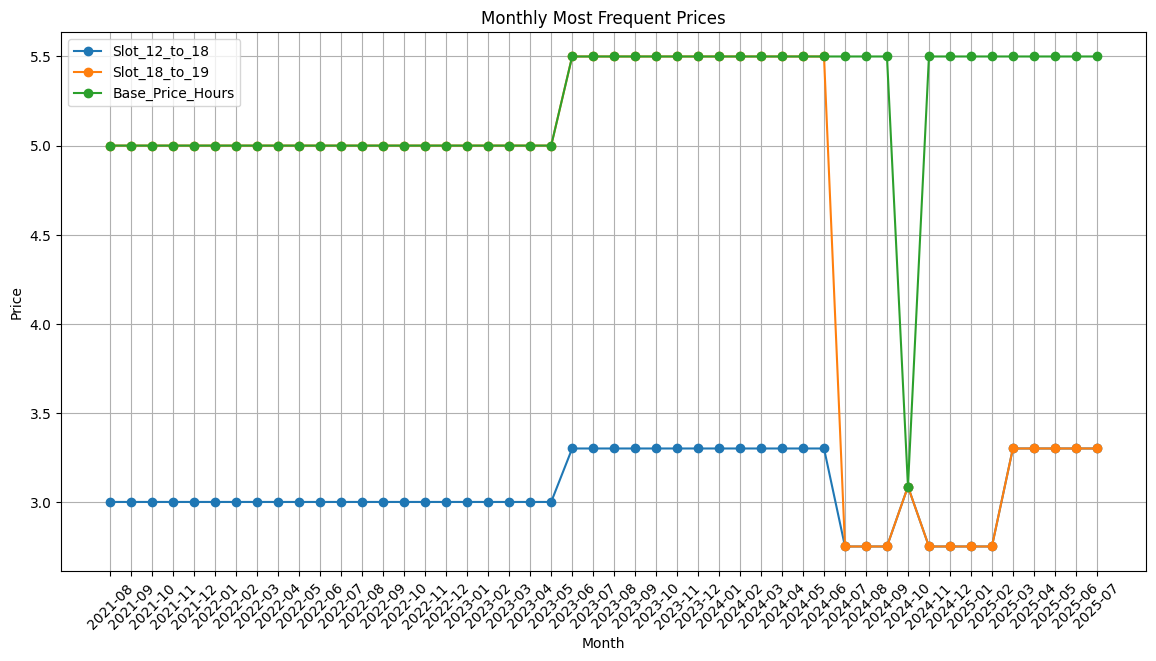

In [143]:
# plot the monthly_mode values
plt.figure(figsize=(14, 7))
plt.plot(monthly_mode['Month'].astype(str), monthly_mode['Slot_12_to_18'], label='Slot_12_to_18', marker='o')
plt.plot(monthly_mode['Month'].astype(str), monthly_mode['Slot_18_to_19'], label='Slot_18_to_19', marker='o')
plt.plot(monthly_mode['Month'].astype(str), monthly_mode['Base_Price_Hours'], label='Base_Price_Hours', marker='o')
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Monthly Most Frequent Prices')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [144]:
# now i want to merge this monthly_mode with daily_prices on Month column
daily_prices = pd.merge(daily_prices, monthly_mode, on='Month', suffixes=('', '_Monthly_Mode'))
daily_prices.head(10)

Time_Slot,Sale_Date,Base_Price_Hours,Outside_Sale_Hours,Slot_12_to_18,Slot_18_to_19,Month,Slot_12_to_18_Monthly_Mode,Slot_18_to_19_Monthly_Mode,Base_Price_Hours_Monthly_Mode
0,2021-08-19,5.0,NaN,0.0,0.0,2021-08,3.0,5.0,5.0
1,2021-08-23,5.0,NaN,3.0,0.0,2021-08,3.0,5.0,5.0
2,2021-08-24,5.0,NaN,0.0,5.0,2021-08,3.0,5.0,5.0
3,2021-08-25,5.0,NaN,0.0,0.0,2021-08,3.0,5.0,5.0
4,2021-08-26,5.0,NaN,0.0,5.0,2021-08,3.0,5.0,5.0
5,2021-08-27,5.0,NaN,3.0,5.0,2021-08,3.0,5.0,5.0
6,2021-08-29,5.0,NaN,3.0,0.0,2021-08,3.0,5.0,5.0
7,2021-08-30,5.0,NaN,3.0,5.0,2021-08,3.0,5.0,5.0
8,2021-08-31,5.0,NaN,3.0,5.0,2021-08,3.0,5.0,5.0
9,2021-09-01,5.0,NaN,3.0,0.0,2021-09,3.0,5.0,5.0


In [145]:
# before filling the NaN values (0 values) i want to add new columns for each columns to know if the price changed or not
# if the price equal to 0 then the price changed
daily_prices["Base_Price_Hours_Changed"] = daily_prices["Base_Price_Hours"].eq(0)
daily_prices["Slot_12_to_18_Changed"] = daily_prices["Slot_12_to_18"].eq(0)
daily_prices["Slot_18_to_19_Changed"] = daily_prices["Slot_18_to_19"].eq(0)
daily_prices.head(10)

Time_Slot,Sale_Date,Base_Price_Hours,Outside_Sale_Hours,Slot_12_to_18,Slot_18_to_19,Month,Slot_12_to_18_Monthly_Mode,Slot_18_to_19_Monthly_Mode,Base_Price_Hours_Monthly_Mode,Base_Price_Hours_Changed,Slot_12_to_18_Changed,Slot_18_to_19_Changed
0,2021-08-19,5.0,NaN,0.0,0.0,2021-08,3.0,5.0,5.0,False,True,True
1,2021-08-23,5.0,NaN,3.0,0.0,2021-08,3.0,5.0,5.0,False,False,True
2,2021-08-24,5.0,NaN,0.0,5.0,2021-08,3.0,5.0,5.0,False,True,False
3,2021-08-25,5.0,NaN,0.0,0.0,2021-08,3.0,5.0,5.0,False,True,True
4,2021-08-26,5.0,NaN,0.0,5.0,2021-08,3.0,5.0,5.0,False,True,False
5,2021-08-27,5.0,NaN,3.0,5.0,2021-08,3.0,5.0,5.0,False,False,False
6,2021-08-29,5.0,NaN,3.0,0.0,2021-08,3.0,5.0,5.0,False,False,True
7,2021-08-30,5.0,NaN,3.0,5.0,2021-08,3.0,5.0,5.0,False,False,False
8,2021-08-31,5.0,NaN,3.0,5.0,2021-08,3.0,5.0,5.0,False,False,False
9,2021-09-01,5.0,NaN,3.0,0.0,2021-09,3.0,5.0,5.0,False,False,True


In [146]:
# now from daily_prices i want to fill the NaN values with most frequent value of that month  for base price, slot_12_to_18 and slot_18_to_19
daily_prices['Slot_12_to_18'] = daily_prices.apply(
    lambda row: row['Slot_12_to_18_Monthly_Mode'] if row['Slot_12_to_18'] == 0 else row['Slot_12_to_18'], axis=1)
daily_prices['Slot_18_to_19'] = daily_prices.apply(
    lambda row: row['Slot_18_to_19_Monthly_Mode'] if row['Slot_18_to_19'] == 0 else row['Slot_18_to_19'], axis=1)
daily_prices['Base_Price_Hours'] = daily_prices.apply(
    lambda row: row['Base_Price_Hours_Monthly_Mode'] if row['Base_Price_Hours'] == 0 else row['Base_Price_Hours'], axis=1)
daily_prices = daily_prices.drop(columns=['Slot_12_to_18_Monthly_Mode', 'Slot_18_to_19_Monthly_Mode', 'Base_Price_Hours_Monthly_Mode', 'Month'])
daily_prices.head(10)

Time_Slot,Sale_Date,Base_Price_Hours,Outside_Sale_Hours,Slot_12_to_18,Slot_18_to_19,Base_Price_Hours_Changed,Slot_12_to_18_Changed,Slot_18_to_19_Changed
0,2021-08-19,5.0,NaN,3.0,5.0,False,True,True
1,2021-08-23,5.0,NaN,3.0,5.0,False,False,True
2,2021-08-24,5.0,NaN,3.0,5.0,False,True,False
3,2021-08-25,5.0,NaN,3.0,5.0,False,True,True
4,2021-08-26,5.0,NaN,3.0,5.0,False,True,False
5,2021-08-27,5.0,NaN,3.0,5.0,False,False,False
6,2021-08-29,5.0,NaN,3.0,5.0,False,False,True
7,2021-08-30,5.0,NaN,3.0,5.0,False,False,False
8,2021-08-31,5.0,NaN,3.0,5.0,False,False,False
9,2021-09-01,5.0,NaN,3.0,5.0,False,False,True


In [147]:
# i want the range of dates from min to max date , and fill the missing dates with forward fill method or back fill method
all_dates = pd.date_range(start=daily_prices['Sale_Date'].min(), end=daily_prices['Sale_Date'].max())
all_dates_df = pd.DataFrame(all_dates, columns=['Sale_Date'])
all_dates_df["Sale_Date"] = all_dates_df["Sale_Date"].dt.date
daily_prices = pd.merge(all_dates_df, daily_prices, on='Sale_Date', how='left')
daily_prices = daily_prices.sort_values('Sale_Date')
daily_prices.head(10)

,Sale_Date,Base_Price_Hours,Outside_Sale_Hours,Slot_12_to_18,Slot_18_to_19,Base_Price_Hours_Changed,Slot_12_to_18_Changed,Slot_18_to_19_Changed
0,2021-08-19,5.0,NaN,3.0,5.0,False,True,True
1,2021-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-08-23,5.0,NaN,3.0,5.0,False,False,True
5,2021-08-24,5.0,NaN,3.0,5.0,False,True,False
6,2021-08-25,5.0,NaN,3.0,5.0,False,True,True
7,2021-08-26,5.0,NaN,3.0,5.0,False,True,False
8,2021-08-27,5.0,NaN,3.0,5.0,False,False,False
9,2021-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
# fill the NaN values with forward fill method or back fill method
daily_prices["Base_Price_Hours"] = daily_prices["Base_Price_Hours"].ffill().bfill()
daily_prices["Slot_12_to_18"] = daily_prices["Slot_12_to_18"].ffill().bfill()
daily_prices["Slot_18_to_19"] = daily_prices["Slot_18_to_19"].ffill().bfill()
# fill the NaN values in the "Base_Price_Hours_Changed" , "Slot_12_to_18_Changed" and "Slot_18_to_19_Changed" columns with True
# .fillna(True) fills the missing values
# .astype(bool) explicitly converts the column to the boolean type
daily_prices["Base_Price_Hours_Changed"] = daily_prices["Base_Price_Hours_Changed"].fillna(True).astype(bool)
daily_prices["Slot_12_to_18_Changed"] = daily_prices["Slot_12_to_18_Changed"].fillna(True).astype(bool)
daily_prices["Slot_18_to_19_Changed"] = daily_prices["Slot_18_to_19_Changed"].fillna(True).astype(bool)
daily_prices.head(10)

C:\Users\fadia\AppData\Local\Temp\ipykernel_12860\1294513242.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily_prices["Base_Price_Hours_Changed"] = daily_prices["Base_Price_Hours_Changed"].fillna(True).astype(bool)
C:\Users\fadia\AppData\Local\Temp\ipykernel_12860\1294513242.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily_prices["Slot_12_to_18_Changed"] = daily_prices["Slot_12_to_18_Changed"].fillna(True).astype(bool)
C:\Users\fadia\AppData\Local\Temp\ipykernel_12860\1294513242.py:10: FutureWarning: Downcasting object dtype arrays on .f

,Sale_Date,Base_Price_Hours,Outside_Sale_Hours,Slot_12_to_18,Slot_18_to_19,Base_Price_Hours_Changed,Slot_12_to_18_Changed,Slot_18_to_19_Changed
0,2021-08-19,5.0,NaN,3.0,5.0,False,True,True
1,2021-08-20,5.0,NaN,3.0,5.0,True,True,True
2,2021-08-21,5.0,NaN,3.0,5.0,True,True,True
3,2021-08-22,5.0,NaN,3.0,5.0,True,True,True
4,2021-08-23,5.0,NaN,3.0,5.0,False,False,True
5,2021-08-24,5.0,NaN,3.0,5.0,False,True,False
6,2021-08-25,5.0,NaN,3.0,5.0,False,True,True
7,2021-08-26,5.0,NaN,3.0,5.0,False,True,False
8,2021-08-27,5.0,NaN,3.0,5.0,False,False,False
9,2021-08-28,5.0,NaN,3.0,5.0,True,True,True


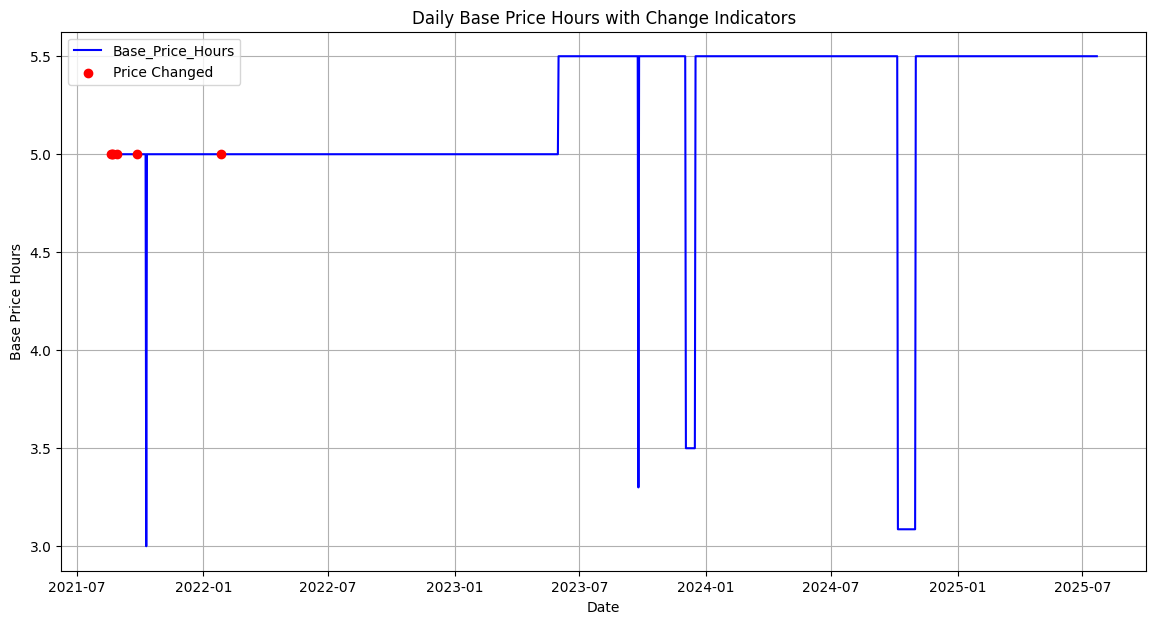

In [149]:
# plot the base price houre and base price houre changed
plt.figure(figsize=(14, 7))
plt.plot(daily_prices['Sale_Date'], daily_prices['Base_Price_Hours'], label='Base_Price_Hours', color='blue')
plt.scatter(daily_prices.loc[daily_prices['Base_Price_Hours_Changed'], 'Sale_Date'], daily_prices.loc[daily_prices['Base_Price_Hours_Changed'], 'Base_Price_Hours'], color='red', label='Price Changed', zorder=5)
plt.xlabel('Date')
plt.ylabel('Base Price Hours')
plt.title('Daily Base Price Hours with Change Indicators')
plt.legend()
plt.grid()
plt.show()


In [150]:
mask = (item_df["Price"]==3) & (item_df["Sale_Hour"]>18)
item_df[mask].head(60)

,Date,Price,Sale_Date,Sale_Hour,Time_Slot
3681,2021-09-03 21:16:04,3.0,2021-09-03,21,Base_Price_Hours
3689,2021-09-03 21:16:05,3.0,2021-09-03,21,Base_Price_Hours
16641,2021-10-10 19:27:12,3.0,2021-10-10,19,Base_Price_Hours
16640,2021-10-10 19:27:12,3.0,2021-10-10,19,Base_Price_Hours
16642,2021-10-10 19:27:12,3.0,2021-10-10,19,Base_Price_Hours
16638,2021-10-10 19:27:12,3.0,2021-10-10,19,Base_Price_Hours
16637,2021-10-10 19:27:12,3.0,2021-10-10,19,Base_Price_Hours
16639,2021-10-10 19:27:12,3.0,2021-10-10,19,Base_Price_Hours
17669,2021-10-13 19:52:00,3.0,2021-10-13,19,Base_Price_Hours
17668,2021-10-13 19:52:00,3.0,2021-10-13,19,Base_Price_Hours
